<a href="https://colab.research.google.com/github/nhuang37/spectral-inspired-gnn/blob/main/power_convergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import math
import random
import os
import numpy as np
from numpy import linalg as LA
import numpy.random as npr
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from scipy.sparse.linalg import eigsh, eigs
from scipy.linalg import hadamard, subspace_angles,orthogonal_procrustes
import itertools

### Common helper functions

In [64]:
#src: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def get_angle(v1, v2):
    """ Returns the angle between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return np.rad2deg(angle)

def compute_pairs(emb_gnn, ASE):
  '''
  compute pairwise angles of GNN embedding and ASEs
  '''
  k = emb_gnn.shape[1]
  angles = []
  #combs = itertools.combinations(range(k), 2)
  #for (i,j) in combs:
  for i in range(emb_gnn.shape[1]):
    min_angle = np.zeros(ASE.shape[1])
    for j in range(ASE.shape[1]):
      min_angle[j] = get_angle(emb_gnn[:,i], ASE[:,j])
    angles.append(min_angle.min())
  return np.array(angles)

In [3]:
def power_iterate(g, feat, K, rw=False, include_feat=True, upper_tri=False):
    """
    Precompute power-iterated features
    g: graph, numpy array (n by n)
    feat: features
    Return: a list with length-K of feature matrices, each with shape (n by d)
    If rw: use D^{-1}A instead of A as the graph operators
    """
    if include_feat:
      powers = [feat]
    else:
      powers = []
    if rw:
      Dinv = 1 / g.sum(axis=1)
      g = g * Dinv[:, None]
    for iter in range(K):
      #message passing
      tildeU = g @ feat
      #normalization
      if upper_tri:
        normalizer = np.linalg.pinv(np.triu(tildeU.T @ tildeU))
      else:
        normalizer = np.linalg.pinv(tildeU.T @ tildeU)
      feat = tildeU @ normalizer #scaled eigenvector (arbitrary rotated if upper_tri is False)
      col_norm = np.linalg.norm(feat, axis=0)
      powers.append(feat / col_norm)
    return powers

In [4]:
def construct_2BSBM(n, p, q, seed=0):
  '''
  Generate a random (n)-nodes symmetric 2-block SBM
  '''
  assert n % 2 == 0, "must pass in even number of nodes"
  probs = [[p,q],[q,p]]
  nvecs = [n//2, n//2]
  graph = nx.stochastic_block_model(nvecs, probs, seed=seed)
  return nx.to_numpy_array(graph)

def construct_graph(n, nvecs, p_d, q_d, p_s, q_s, a, b, seed=0):
  '''
  Generate a random (n)-nodes 4-block symmetric SBM using probability matrix prob
  n: total number of nodes
  nvecs: number of nodes per block
  p_d, q_d: dense block connectivity probability
  p_s, q_s: sparse block connectivity probability
  a, b: cross edges
  probability matrix B:
    [[p_d, q_d, a, b],[q_d, p_d, b, a],[a, b, p_s, q_s], [b, a, q_s, p_s]]
  return DGL_graph; numpy adjacency matrix
  '''
  assert n % 4 == 0, "must pass in node numbers that can be divided by 4 (4-block symmetric SBM!)"
  #sizes = [n//4, n//4, n//4, n//4]
  probs = [[p_d, q_d, a, b],[q_d, p_d, b, a],[a, b, p_s, q_s], [b, a, q_s, p_s]]
  graph = nx.stochastic_block_model(nvecs, probs, seed=seed)
  return nx.to_numpy_array(graph)

def gaussian_features(n, in_feats, cov_scale, mean_scale=1, seed=0):
  '''
  n: number of nodes per block
  in_feats: input feature dimension
  cov_scale: scaling factor for covariance matrix
  return (2n x in_feats) feature matrix, where the first n rows are sample iid from N([1,...1], cov_scale*I),
  the last n rows are sample iid from N([-1,...-1], cov_scale*I)
  '''
  np.random.seed(seed)
  mean = mean_scale*np.ones(in_feats)
  cov = cov_scale*np.eye(in_feats)
  feat_1 = np.random.multivariate_normal(mean, cov, n//2)
  feat_2 = np.random.multivariate_normal(-mean, cov, n//2)
  features = np.concatenate((feat_1, feat_2), axis=0)
  return features


In [5]:
def feature_classify(features, Ys, train_mask):
  '''
  features: node features
  Ys: classification label
  train_mask: mask for trainingset
  return: test_acc, Yhats (entry = train labels if available)
  '''
  #clf = svm.SVC(kernel='linear', max_iter=500)
  K = min(len(np.unique(Ys))-1, features.shape[1])
  clf = LinearDiscriminantAnalysis(n_components=K)
  clf.fit(features[train_mask], Ys[train_mask])
  Yhats = clf.predict(features)
  Yhats[train_mask] = Ys[train_mask]
  return clf.score(features[~train_mask], Ys[~train_mask]), len(Ys[~train_mask]), Yhats

In [6]:
def emb_ASE(A, k=2):
  '''
  ASE embedding
  '''
  # u, s, v = np.linalg.svd(A, hermitian=True)
  # return u[:, :k] * s[:k]
  evalues, evectors = eigsh(A, k=k)
  return evectors[:, :k]

def emb_covX(Xouter, k=2):
  '''
  top-k eigenvector of covariance
  '''
  evaluesX, evectorsX = eigsh(Xouter, k=k)
  return evectorsX[:, :k]

def emb_SGC(A, feats, k=2, n_layer=1):
  '''
  SGC embedding using identity (node identifier) as initial feature
  A: with self-loop
  '''
  Dinv = 1 / A.sum(axis=1)
  A_rw = A * Dinv[:, None]
  out = feats
  for layer in range(n_layer):
    out = A_rw @ feats
  return out



### PowerEmbed simulation

In [71]:
def test_power_iter(n, p, q, K, k=2, self_loop=True, runs=30, upper_tri=False):
  results = []
  for run in range(runs): #(30)
    g = construct_2BSBM(n, p, q, seed=run)
    #evalues, evectors = eigsh(g, k=k) #arbitrarily ordered
    u, s, vh = np.linalg.svd(g, hermitian=True)
    if self_loop:
      g = g + np.eye(n)
    X = np.random.rand(n,k)
    powers = power_iterate(g, X, K, include_feat=False, upper_tri=upper_tri)

  #return u, powers
    angles = np.zeros((K,k))
    for t, u_est in enumerate(powers):
      #procrustes to mod out the orthogonal transform
      R, sca = orthogonal_procrustes(u_est, u[:,:2])
      u_est = u_est @ R
      angles[t,0] = get_angle(u_est[:,0] , u[:,0])
      angles[t,1] = get_angle(u_est[:,1], u[:,1])

    results.append(angles)
  return np.array(results)

def convergence_rate(evalue, K=2):
  ratios = []
  for k in range(K):
    ratios.append((evalue[:,k+1]/evalue[:,k]).mean())
  return ratios

In [76]:
%%time
K = 100
n = 500
runs = 10
test_power_runs_dense = test_power_iter(n=n, p=1/2, q=1/3, K=K, runs=runs)
test_power_runs_med = test_power_iter(n=n, p=1/10, q=1/15, K=K, runs=runs)
test_power_runs_sparse = test_power_iter(n=n, p=1/20, q=1/30, K=K, runs=runs)

CPU times: user 13.4 s, sys: 29.2 s, total: 42.6 s
Wall time: 6.72 s


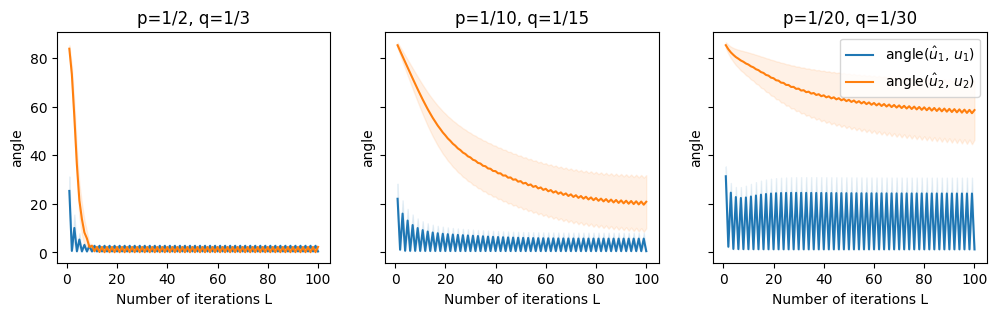

In [77]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,3), dpi=100)

results = [test_power_runs_dense, test_power_runs_med, test_power_runs_sparse]
xs = np.arange(1,K+1)
for i, result in enumerate(results):
  mean = result.mean(axis=0)
  stderr = result.std(axis=0) / np.sqrt(runs)
  axs[i].plot(xs, mean[:,0], label=r'angle($\hat{u}_1$, $u_1$)', color='tab:blue')
  axs[i].fill_between(xs, mean[:,0]+stderr[:,0], mean[:,0]-stderr[:,0], alpha=0.1, color='tab:blue')
  axs[i].plot(np.arange(1,K+1), mean[:,1], label=r'angle($\hat{u}_2$, $u_2$)', color='tab:orange')
  axs[i].fill_between(xs, mean[:,1]+stderr[:,1], mean[:,1]-stderr[:,1], alpha=0.1, color='tab:orange')

  axs[i].set_xlabel("Number of iterations L")
  axs[i].set_ylabel("angle")

axs[0].set_title(r'p=1/2, q=1/3')
axs[1].set_title(r'p=1/10, q=1/15')
axs[2].set_title(r'p=1/20, q=1/30')
plt.legend()
plt.show()